# Softmax 练习


*完成并连同作业上交你完整的工作表(包括其输出及工作表外的任何支持代码)，更多详情请参见课程网站上的[作业页面](http://vision.stanford.edu/teaching/cs231n/assignments.html)。*

这个练习类似于SVM练习,你会:
- 为Softmax分类器实现一个完全向量化的**损耗函数**
- 实现其**解析梯度**的全向量化表达式
- **检查你的实现**与数值梯度
- 使用验证集**调整学习率和正则化**强度
- 用**SGD优化**损耗函数
- **可视化**最后学习的重量


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 9.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
  """
  Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
  it for the linear classifier. These are the same steps as we used for the
  SVM, but condensed to a single function.  
  """
  # Load the raw CIFAR-10 data
  cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
  # subsample the data
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]
  mask = np.random.choice(num_training, num_dev, replace=False)
  X_dev = X_train[mask]
  y_dev = y_train[mask]
  
  # Preprocessing: reshape the image data into rows
  X_train = np.reshape(X_train, (X_train.shape[0], -1))
  X_val = np.reshape(X_val, (X_val.shape[0], -1))
  X_test = np.reshape(X_test, (X_test.shape[0], -1))
  X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
  
  # Normalize the data: subtract the mean image
  mean_image = np.mean(X_train, axis = 0)
  X_train -= mean_image
  X_val -= mean_image
  X_test -= mean_image
  X_dev -= mean_image
  
  # add bias dimension and transform into columns
  X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
  X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
  X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
  X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
  
  return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print ('Train data shape: ', X_train.shape)
print ('Train labels shape: ', y_train.shape)
print ('Validation data shape: ', X_val.shape)
print ('Validation labels shape: ', y_val.shape)
print ('Test data shape: ', X_test.shape)
print ('Test labels shape: ', y_test.shape)
print ('dev data shape: ', X_dev.shape)
print ('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax 分类器

本节的代码将全部写在**cs231n/classifier /softmax.py**中


In [3]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print ('loss: %f' % loss)
print ('sanity check: %f' % (-np.log(0.1)))

loss: 2.352635
sanity check: 2.302585


## Inline Question 1:
为什么我们期望损失值接近-log(0.1)?请简要解释

**Your answer:** *Fill this in*

- 因为W随机初始化（有10个类别），所以每个类计算的得分是相同的，经过SoftMax之后的概率是一样的，因此每一个类的概率都是0.1，求得交叉熵也就是-log(0.1)


In [5]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 1e2)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -1.509718 analytic: -1.509718, relative error: 4.266408e-09
numerical: 0.862750 analytic: 0.862750, relative error: 4.505671e-09
numerical: 1.263459 analytic: 1.263459, relative error: 5.402075e-08
numerical: -3.421720 analytic: -3.421720, relative error: 1.897553e-09
numerical: -0.557343 analytic: -0.557343, relative error: 3.774957e-08
numerical: 1.287508 analytic: 1.287508, relative error: 6.741293e-08
numerical: 1.336710 analytic: 1.336710, relative error: 5.571692e-08
numerical: -1.449432 analytic: -1.449432, relative error: 1.354936e-08
numerical: -1.259372 analytic: -1.259372, relative error: 1.024200e-08
numerical: 1.735493 analytic: 1.735493, relative error: 4.379149e-08
numerical: -0.386872 analytic: -0.386872, relative error: 6.325432e-08
numerical: -4.894356 analytic: -4.894356, relative error: 1.351140e-08
numerical: 1.749314 analytic: 1.749314, relative error: 5.216199e-08
numerical: 0.683288 analytic: 0.683288, relative error: 1.809120e-07
numerical: 1.983511 

In [8]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print ('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print ('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print ('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print ('Gradient difference: %f' % grad_difference)

naive loss: 2.352635e+00 computed in 0.133642s
vectorized loss: 2.352635e+00 computed in 0.003989s
Loss difference: 0.000000
Gradient difference: 0.000000


In [9]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [5e4, 1e6]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
for rate in learning_rates:
    for reg in regularization_strengths:
        sm = Softmax()
        loss_hist = sm.train(X_train, y_train, learning_rate=rate, reg=reg, num_iters=5000, verbose=True)
        y_train_pred = sm.predict(X_train)
        acc_tr = np.mean(y_train == y_train_pred)
        y_val_pred = sm.predict(X_val)
        acc_val = np.mean(y_val == y_val_pred)
        
        results[(rate, reg)] = (acc_tr, acc_val)
        if acc_val > best_val:
            best_val = acc_val
            best_softmax = sm
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print ('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print ('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 5000: loss 778.474061
iteration 100 / 5000: loss 285.719183
iteration 200 / 5000: loss 105.871889
iteration 300 / 5000: loss 40.077869
iteration 400 / 5000: loss 16.006308
iteration 500 / 5000: loss 7.166896
iteration 600 / 5000: loss 4.015165
iteration 700 / 5000: loss 2.801743
iteration 800 / 5000: loss 2.322427
iteration 900 / 5000: loss 2.212780
iteration 1000 / 5000: loss 2.095009
iteration 1100 / 5000: loss 2.072824
iteration 1200 / 5000: loss 2.132577
iteration 1300 / 5000: loss 2.068940
iteration 1400 / 5000: loss 2.086209
iteration 1500 / 5000: loss 2.059195
iteration 1600 / 5000: loss 2.049228
iteration 1700 / 5000: loss 2.121531
iteration 1800 / 5000: loss 2.098930
iteration 1900 / 5000: loss 2.063414
iteration 2000 / 5000: loss 2.121234
iteration 2100 / 5000: loss 2.113409
iteration 2200 / 5000: loss 2.070880
iteration 2300 / 5000: loss 2.060384
iteration 2400 / 5000: loss 2.073054
iteration 2500 / 5000: loss 2.133219
iteration 2600 / 5000: loss 2.092272
itera

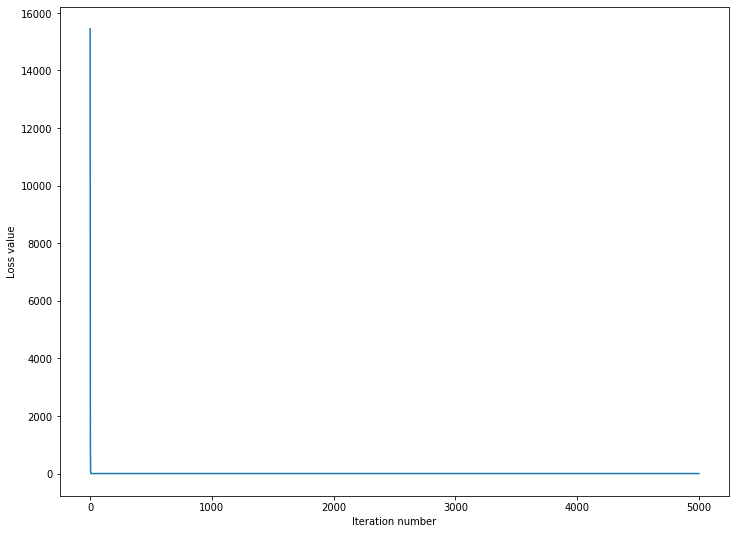

In [10]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [11]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print ('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.346000


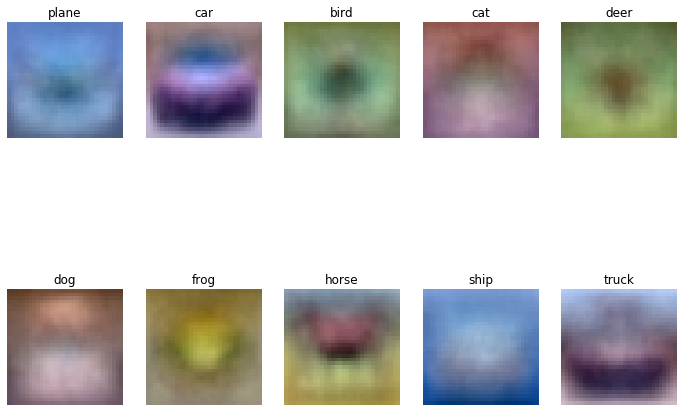

In [12]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
  plt.subplot(2, 5, i + 1)
  
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])